# Sample Similarity

The goal of a Resemblance Model is understanding how different two samples are from a multivariate perspective. For instance, if you suspect that your Out-Of-Time Test set may have a different distribution than the In-Time Train set, you can detect that using the Resemblance Model.

<img src="resemblance_schema.png" width="900">

Having two samples `X1` and `X2` with the same set of features, one can analyse how well a model can recognize which dataset a randomly selected row comes from. The Resemblance model assigns label `0` to `X1` dataset, and label `1` to `X2`. Then, the data is shuffled and split into Train split (`X_train`, `y_train`) and Test split (`X_test`, `y_test`).

The user provides a binary classifier that is then fitted on the Train split and evaluated on both Train and Test.
Interpreting such model allows to understand, which features and interactions between them differ between these two samples.

It is crucial that the model does not overfit or underfit, because interpretation of such model will lead to wrong conclusions. Therefore, you should try fitting the model with a couple different hyperparameter settings, and make sure that `Train AUC` is not significantly higher than `Test AUC`

Once you have the final Resemblance Model, the `Test AUC` significantly above 0.5 indicates predictive power of the model, as well as the change in the distribution between `X1` and `X2`. The higher the `Test AUC`, the larger the difference between two datasets.

Then you can use interpret the model, in order to understand the patterns that the model has learned.
There are two classes in `probatus` that allow you to analyse, which features have changed between two samples.

**SHAPImportanceResemblance (Recommended)** - Trains a Resemblance model based on a **tree classifier**, then it uses SHAP library to analyse the differences in features between the two samples. The main advantage of using this method is its high speed, better understanding of the relations in the data and handling of categorical features and missing values.

**PermutationImportanceResemblance** - Trains a Resemblance model for **any provided classifier**, and uses Permutation Importance to analyse, which features the model relies on. It is significantly slower, and requires preprocessing of the data before training the resemblance model.

## Setup

In [1]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

# Prepare two samples
feature_names = ['f1', 'f2', 'f3', 'f4']
X1 = pd.DataFrame(make_classification(n_samples=1000, n_features=4, random_state=0)[0], columns=feature_names)
X2 = pd.DataFrame(make_classification(n_samples=1000, n_features=4, shift=0.5, random_state=0)[0], columns=feature_names)

# Prepare model
clf = RandomForestClassifier(n_estimators = 100, max_depth=2, random_state=0)

## SHAP Importance Resemblance Model for Tree models

Below you can see an example of how to use the model:

In [2]:
from probatus.sample_similarity import SHAPImportanceResemblance

rm = SHAPImportanceResemblance(clf)
feature_importance, train_auc, test_auc = rm.fit_compute(X1, X2, column_names=feature_names, return_auc=True)

display(feature_importance)

Finished model training: Train AUC 0.823, Test AUC 0.798


Train AUC > Test AUC, which might indicate an overfit. 
Strong overfit might lead to misleading conclusions when analysing feature importance. Consider retraining with more regularization applied to the model.


,column_name,shap_importance
0,f1,0.067270
2,f3,0.064015
1,f2,0.029531
3,f4,0.027418


By looking into the above results, one can conclude that the two samples significantly differ, since the Test AUC of the model is very high.

The table shows, which features have the highest importance, while making the prediction. We can automatically plot the results using the below function.

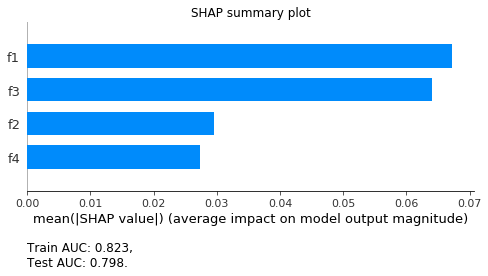

In [3]:
ax = rm.plot()

In order to get more insights of the change in underlying relations in the data, let's plot a dot summary plot.

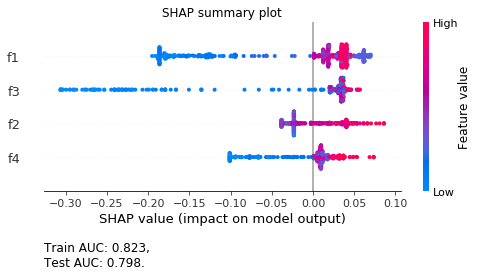

In [4]:
ax = rm.plot(plot_type='dot')

We can see that second sample have higher values in all the features.

## Permutation Importance Resemblance Model

Below we show the example on how to use the PermutationImportanceResemblance

In [5]:
from probatus.sample_similarity import PermutationImportanceResemblance
perm = PermutationImportanceResemblance(clf)

feature_importance, train_auc, test_auc = perm.fit_compute(X1, X2, column_names=feature_names, return_auc=True)
display(feature_importance)

Finished model training: Train AUC 0.823, Test AUC 0.798


Train AUC > Test AUC, which might indicate an overfit. 
Strong overfit might lead to misleading conclusions when analysing feature importance. Consider retraining with more regularization applied to the model.


,mean_importance,std_importance
f3,0.132218,0.014416
f1,0.091361,0.017274
f2,0.044393,0.011365
f4,0.013746,0.009333


Same as before, we can get more insights into the importance of the features. However, now we can also analyse standard deviation of the permutation importance. High std might indicate that permutation of this feature has a higher or lower impact only in part of the available samples, while low std, indicates a consistent effect.

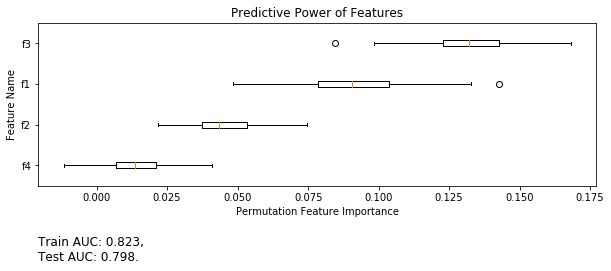

In [6]:
perm.plot()

## Visualize the difference in the most important feature

We can also use the utils to provide more insights into the feature distribution difference in the two samples.

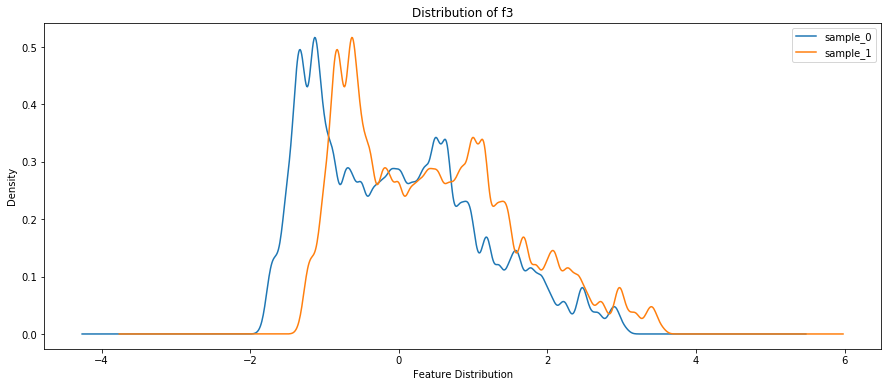

In [7]:
from probatus.utils.plots import plot_distributions_of_feature

feature_distributions = [X1['f3'], X2['f3']]
plot_distributions_of_feature(feature_distributions, plot_perc_outliers_removed=0.01)